In [ ]:
!ls /usr/local/cuda*

/usr/local/cuda:
bin		   EULA.txt  libnvvp	       nvvm-prev  src
compat		   extras    nsightee_plugins  README	  targets
compute-sanitizer  include   nvml	       samples	  tools
DOCS		   lib64     nvvm	       share	  version.json

/usr/local/cuda-11:
bin		   EULA.txt  libnvvp	       nvvm-prev  src
compat		   extras    nsightee_plugins  README	  targets
compute-sanitizer  include   nvml	       samples	  tools
DOCS		   lib64     nvvm	       share	  version.json

/usr/local/cuda-11.2:
bin		   EULA.txt  libnvvp	       nvvm-prev  src
compat		   extras    nsightee_plugins  README	  targets
compute-sanitizer  include   nvml	       samples	  tools
DOCS		   lib64     nvvm	       share	  version.json


In [ ]:
!nvidia-smi

Fri Dec 16 17:10:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%writefile matrix.cu

#include <stdio.h>
#include <stdlib.h>
#include <assert.h>
#include <sys/time.h>

#define BLOCK_SIZE 16

double cpuSecond() {
   struct timeval tp;
   gettimeofday(&tp,NULL);
   return ((double)tp.tv_sec + (double)tp.tv_usec*1.e-6);
}


__global__ void gpu_matrix_mult(int *a,int *b, int *c, int m, int n, int k)
{ 
    int row = blockIdx.y * blockDim.y + threadIdx.y; 
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    int sum = 0;
    if( col < k && row < m) 
    {
        for(int i = 0; i < n; i++) 
        {
            sum += a[row * n + i] * b[i * k + col];
        }
        c[row * k + col] = sum;
    }
} 


__global__ void gpu_square_matrix_mult(int *d_a, int *d_b, int *d_result, int n) 
{
    __shared__ int tile_a[BLOCK_SIZE][BLOCK_SIZE];
    __shared__ int tile_b[BLOCK_SIZE][BLOCK_SIZE];

    int row = blockIdx.y * BLOCK_SIZE + threadIdx.y;
    int col = blockIdx.x * BLOCK_SIZE + threadIdx.x;
    int tmp = 0;
    int idx;

    for (int sub = 0; sub < gridDim.x; ++sub) 
    {
        idx = row * n + sub * BLOCK_SIZE + threadIdx.x;
        if(idx >= n*n)
        {
            // n may not divisible by BLOCK_SIZE
            tile_a[threadIdx.y][threadIdx.x] = 0;
        }
        else
        {
            tile_a[threadIdx.y][threadIdx.x] = d_a[idx];
        }

        idx = (sub * BLOCK_SIZE + threadIdx.y) * n + col;
        if(idx >= n*n)
        {
            tile_b[threadIdx.y][threadIdx.x] = 0;
        }  
        else
        {
            tile_b[threadIdx.y][threadIdx.x] = d_b[idx];
        }
        __syncthreads();

        for (int k = 0; k < BLOCK_SIZE; ++k) 
        {
            tmp += tile_a[threadIdx.y][k] * tile_b[k][threadIdx.x];
        }
        __syncthreads();
    }
    if(row < n && col < n)
    {
        d_result[row * n + col] = tmp;
    }
}


__global__ void gpu_matrix_transpose(int* mat_in, int* mat_out, unsigned int rows, unsigned int cols) 
{
    unsigned int idx = blockIdx.x * blockDim.x + threadIdx.x;
    unsigned int idy = blockIdx.y * blockDim.y + threadIdx.y;

    if (idx < cols && idy < rows) 
    {
        unsigned int pos = idy * cols + idx;
        unsigned int trans_pos = idx * rows + idy;
        mat_out[trans_pos] = mat_in[pos];
    }
}

void cpu_matrix_mult(int *h_a, int *h_b, int *h_result, int m, int n, int k) {
    for (int i = 0; i < m; ++i) 
    {
        for (int j = 0; j < k; ++j) 
        {
            int tmp = 0.0;
            for (int h = 0; h < n; ++h) 
            {
                tmp += h_a[i * n + h] * h_b[h * k + j];
            }
            h_result[i * k + j] = tmp;
        }
    }
}


int main(int argc, char const *argv[])
{
    int m, n, k;
    /* Fixed seed for illustration */
    srand(3333);
    printf("please type in m n and k\n");
    scanf("%d %d %d", &m, &n, &k);

    // allocate memory in host RAM, h_cc is used to store CPU result
    int *h_a, *h_b, *h_c, *h_cc;
    cudaMallocHost((void **) &h_a, sizeof(int)*m*n);
    cudaMallocHost((void **) &h_b, sizeof(int)*n*k);
    cudaMallocHost((void **) &h_c, sizeof(int)*m*k);
    cudaMallocHost((void **) &h_cc, sizeof(int)*m*k);

    // random initialize matrix A
    for (int i = 0; i < m; ++i) {
        for (int j = 0; j < n; ++j) {
            h_a[i * n + j] = rand() % 1024;
        }
    }

    // random initialize matrix B
    for (int i = 0; i < n; ++i) {
        for (int j = 0; j < k; ++j) {
            h_b[i * k + j] = rand() % 1024;
        }
    }

    float gpu_elapsed_time_ms, cpu_elapsed_time_ms;

    // some events to count the execution time
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    // start to count execution time of GPU version
    cudaEventRecord(start, 0);
    // Allocate memory space on the device 
    int *d_a, *d_b, *d_c;
    cudaMalloc((void **) &d_a, sizeof(int)*m*n);
    cudaMalloc((void **) &d_b, sizeof(int)*n*k);
    cudaMalloc((void **) &d_c, sizeof(int)*m*k);

    // copy matrix A and B from host to device memory
    // TIME THIS
    double hTdTime = cpuSecond();
    cudaMemcpy(d_a, h_a, sizeof(int)*m*n, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, h_b, sizeof(int)*n*k, cudaMemcpyHostToDevice);
    cudaDeviceSynchronize();
    double hTdTimeElaplsed = cpuSecond() - hTdTime;

    unsigned int grid_rows = (m + BLOCK_SIZE - 1) / BLOCK_SIZE;
    unsigned int grid_cols = (k + BLOCK_SIZE - 1) / BLOCK_SIZE;
    dim3 dimGrid(grid_cols, grid_rows);
    dim3 dimBlock(BLOCK_SIZE, BLOCK_SIZE);
   
    // Launch kernel 
    //TIME THIS
    double kernelTime = cpuSecond();
    if(m == n && n == k)
    {
        gpu_square_matrix_mult<<<dimGrid, dimBlock>>>(d_a, d_b, d_c, n);    
    }
    else
    {
        gpu_matrix_mult<<<dimGrid, dimBlock>>>(d_a, d_b, d_c, m, n, k);    
    }
    cudaDeviceSynchronize();
    double kernelTimeElaplsed = cpuSecond() - kernelTime;

    // Transefr results from device to host 
    //TIME THIS
    double dThTime = cpuSecond();
    cudaMemcpy(h_c, d_c, sizeof(int)*m*k, cudaMemcpyDeviceToHost);
    cudaDeviceSynchronize();
    double dThTimeElaplsed = cpuSecond() - dThTime;

    cudaThreadSynchronize();
    // time counting terminate
    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);

    // compute time elapse on GPU computing
    cudaEventElapsedTime(&gpu_elapsed_time_ms, start, stop);
    printf("Time elapsed on matrix multiplication of %dx%d . %dx%d on GPU: %f ms.\n\n", m, n, n, k, gpu_elapsed_time_ms);

    // start the CPU version
    cudaEventRecord(start, 0);

    cpu_matrix_mult(h_a, h_b, h_cc, m, n, k);

    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&cpu_elapsed_time_ms, start, stop);
    printf("Time elapsed on matrix multiplication of %dx%d . %dx%d on CPU: %f ms.\n\n", m, n, n, k, cpu_elapsed_time_ms);

    // validate results computed by GPU
    int all_ok = 1;
    for (int i = 0; i < m; ++i)
    {
        for (int j = 0; j < k; ++j)
        {
            //printf("[%d][%d]:%d == [%d][%d]:%d, ", i, j, h_cc[i*k + j], i, j, h_c[i*k + j]);
            if(h_cc[i*k + j] != h_c[i*k + j])
            {
                all_ok = 0;
            }
        }
        //printf("\n");
    }

    // roughly compute speedup
    if(all_ok)
    {
        printf("all results are correct!!!, speedup = %f\n", cpu_elapsed_time_ms / gpu_elapsed_time_ms);
    }
    else
    {
        printf("incorrect results\n");
    }

    printf("Host to Device: %f\n", hTdTimeElaplsed);
    printf("Kernel: %f\n", kernelTimeElaplsed);
    printf("Device to Host: %f\n", dThTimeElaplsed);

    // free memory
    cudaFree(d_a);
    cudaFree(d_b);
    cudaFree(d_c);
    cudaFreeHost(h_a);
    cudaFreeHost(h_b);
    cudaFreeHost(h_c);
    cudaFreeHost(h_cc);
    return 0;
}



Overwriting matrix.cu


In [ ]:
!nvcc matrix.cu -o matrix

matrix.cu: In function ‘int main(int, const char**)’:
matrix.cu:258:23: warning: ‘cudaError_t cudaThreadSynchronize()’ is deprecated [-Wdeprecated-declarations]
     cudaThreadSynchronize();
                       ^
/usr/local/cuda/bin/../targets/x86_64-linux/include/cuda_runtime_api.h:1011:46: note: declared here
 extern __CUDA_DEPRECATED __host__ cudaError_t CUDARTAPI cudaThreadSynchronize(void);
                                              ^~~~~~~~~~~~~~~~~~~~~


In [ ]:
!./matrix

please type in m n and k
1050 1060 1050
Time elapsed on matrix multiplication of 1050x1060 . 1060x1050 on GPU: 11.244896 ms.

Time elapsed on matrix multiplication of 1050x1060 . 1060x1050 on CPU: 5862.668457 ms.

all results are correct!!!, speedup = 521.362610
Host to Device: 0.000759
Kernel: 0.009699
Device to Host: 0.000349


In [ ]:
!/usr/local/cuda-11/bin/nv-nsight-cu-cli --metrics 	sm__warps_active.avg.pct_of_peak_sustained_active matrix

please type in m n and k
511 1023 4094
==PROF== Connected to process 513 (/content/matrix)
==PROF== Profiling "gpu_matrix_mult" - 1: 0%....50%....100% - 1 pass
Time elapsed on matrix multiplication of 511x1023 . 1023x4094 on GPU: 278.681122 ms.

Time elapsed on matrix multiplication of 511x1023 . 1023x4094 on CPU: 14554.444336 ms.

all results are correct!!!, speedup = 52.226158
Host to Device: 0.001603
Kernel: 0.001603
Device to Host: 0.000801
==PROF== Disconnected from process 513
[513] matrix@127.0.0.1
  gpu_matrix_mult(int*, int*, int*, int, int, int), 2022-Dec-16 17:51:37, Context 1, Stream 7
    Section: Command line profiler metrics
    ---------------------------------------------------------------------- --------------- ------------------------------
    sm__warps_active.avg.pct_of_peak_sustained_active                                    %                          98.38
    ---------------------------------------------------------------------- --------------- -----------------

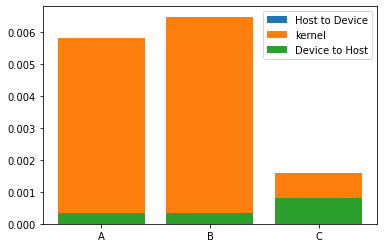

In [ ]:
# Size = 1024 1024 1024
# Host to Device: 0.000714
# Kernel: 0.005817
# Device to Host: 0.000330

# Size = 1050 1050 1050
# Host to Device: 0.000754
# Kernel: 0.006478
# Device to Host: 0.000350

# Size = 1050 1060 1050
# Host to Device: 0.001603
# Kernel: 0.001603
# Device to Host: 0.000801

import matplotlib.pyplot as plt

# Data for the bar chart
x = ['A', 'B', 'C']
y1 = [0.000714,0.000754,0.001603]
y2 = [0.005817,0.006478,0.001603]
y3 = [0.000330,0.000350, 0.000801]

# Create the figure and the axis


# Add the data to the plot
plt.bar(x, y1, label="Host to Device")
plt.bar(x, y2, label="kernel")
plt.bar(x, y3, label="Device to Host")

# Add labels and title
# plt.set_xlabel("Vector size")
# plt.set_ylabel("Time taken")
# plt.set_title("Time taken based on Vector size")
plt.legend()

# Show the plot
plt.show()
